In [ ]:
#Import Files / Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install new libraries
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.4 MB/s eta 0:00:00


In [ ]:
#Import Libraries

import spectral as sp
import spectral.io.envi as envi

import numpy as np
import scipy as sc

import pandas as pd

import sklearn
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
# sns.set()

import joblib

#Set function to convert into rgb image
def to_rgb(x):
    bands = [145,(411+145)//2,411-1]
    rgb = x[...,bands]
    for i in range(3):
        l,u = rgb[...,i].min(), rgb[...,i].max()
        rgb[...,i] = (rgb[...,i] - l) / (u - l)
    return np.clip(rgb,0,1)

## Read / Set the data

In [ ]:
#Input data Image 1

#Path of hdr file image1
hdrFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_195_extracted_image.hdr'

#Path of img file image1
imgFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_195_extracted_image.img'

#Open image with envi
img = envi.open(hdrFile1, imgFile1)

#Load image
hypr_c195 = img.load()

#Set RGB image for plotting
img_rgb = to_rgb(hypr_c195)

#Image shape
hypr_shape = hypr_c195.shape

#Wavelenghts of image
wavelengths = np.array(img.bands.centers)

#Define SWIR wavelenghts
swir_range, = np.where(wavelengths >= 1000)



hypr_c195.shape

(527, 337, 411)

## Apply First Mask 1

Initial Hand mask .tiff file

In [ ]:
#Path to .tiff mask file
tiffFileMask1='/content/drive/MyDrive/SURF/HySpectral Project/data/Core Mask/VN-SWIR_Core_Mask_CMM-111_195@1719_1726.tiff'

#Read image with plt
mask_c195 = plt.imread(tiffFileMask1)

#Select just the image first three channels: [:,:,:3]
mask_c195 = rgb2gray(mask_c195[:,:,:3]).astype(bool)

#Select only data/white parts
hypr = hypr_c195[mask_c195,:]

#Reshape and select just SWIR wavelenghts
hypr = hypr.reshape(-1, 411)
hypr = hypr[:,swir_range]


mask_c195.shape

(527, 337)

### Preprocessing dimensionality-reduction (Define 1st Characterization Pipeline)

In [ ]:
#Principal Component Analysis, Dimensionality Reduction to 5 dimensions
pca = TruncatedSVD(n_components=5)

#Pipleline: Automates preprocessing steps
#Standarized data values into standard format,
pl  = Pipeline([('scale',StandardScaler()),('pca',pca)])
hyprT = pl.fit_transform(hypr)

In [ ]:

#Apply the first mask pipeline (Data X Hyperspectral with first mask)
H = hypr_c195.reshape(-1, 411)
H = H[:,swir_range]
H = pl.transform(H)

H.shape

(177599, 5)

#Finer masking (Apply and Select Kernel Mask 2)

In [ ]:
#Construct Nyostream for kernel approximations. (Speed up kernel methods)
nlf = Nystroem(kernel='rbf', gamma=0.01, n_components=100, random_state=1234)


#Set number of clusters
n_clusters = 5

#Construct pipeline with nlf and K Means to divide into clusters
kM = Pipeline([
    ('features',nlf),
    ('cluster',KMeans(n_clusters=n_clusters, random_state=1234))])

#Train km with H (from first hand mask)
kM.fit(H)

#Predict the labels
labels = kM.predict(H)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-10-9dbf75860256>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  v = cm.get_cmap('jet', n_clusters)


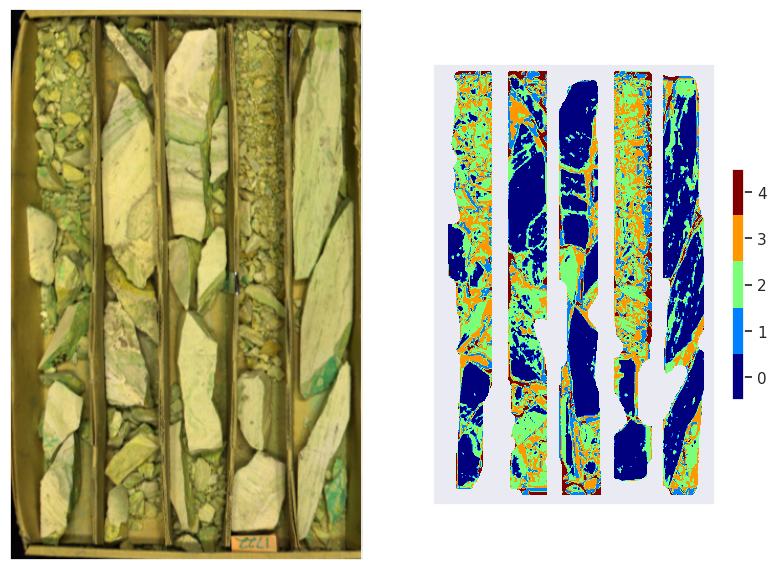

In [ ]:
#Getting rid of the first mask values for plotting
im_labels = labels.reshape(hypr_shape[:2]).astype(float)
im_labels[~mask_c195] = np.nan

#ploting the Kernels to choose sections

v = cm.get_cmap('jet', n_clusters)

plt.figure(figsize=(10,10))
sns.set()

#Plot Original Image
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])


#Plot the kernel clustered image
plt.subplot(1,2,2)
plt.imshow(im_labels, cmap=v, vmin=-0.5, vmax=n_clusters-0.5)
plt.colorbar(ticks=np.arange(0,n_clusters), shrink=0.3)
plt.xticks([])
plt.yticks([])

# plt.tight_layout()
plt.show()

### Choose clusters

Set the Train mask for Image1 for NN

In [ ]:
#Choose Selected clusters:
clusters=[0,2,]

#Create the binary masks (Applying Mask1 and Mask2 with choosen clusters)
Ilv1 = (labels==clusters[0])
for i in range(1,len(clusters)):
    Ilv1 = np.logical_or(Ilv1, labels==clusters[i])

#Define Image with the binary mask indexing
Hlv2 = H[Ilv1]

## Apply and Select Kernel Mask 3

In [ ]:

#Build Second pipeline withthe handpicked clusters
nc2 = 1
#Define second Kernel clustering
clm2 = KMeans(n_clusters=nc2, random_state=1234)
#clm2.fit(nlf.transform(Hlv2))

kM2 = Pipeline([
    ('features',nlf),
    ('cluster',clm2)])

#Train the Pipeline
kM2.fit(Hlv2)

#Predict the labels
labels2 = kM2.predict(H).astype(float)


#Refined labels:

#Get rid of the selected Mask2
labels2[~Ilv1] = np.nan
labels2 = labels2.reshape(hypr_shape[:2])

#Get rid of the initial Mask1
labels2[~mask_c195] = np.nan

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-21-b9d181182dbf>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  v2 = cm.get_cmap('jet', nc2)


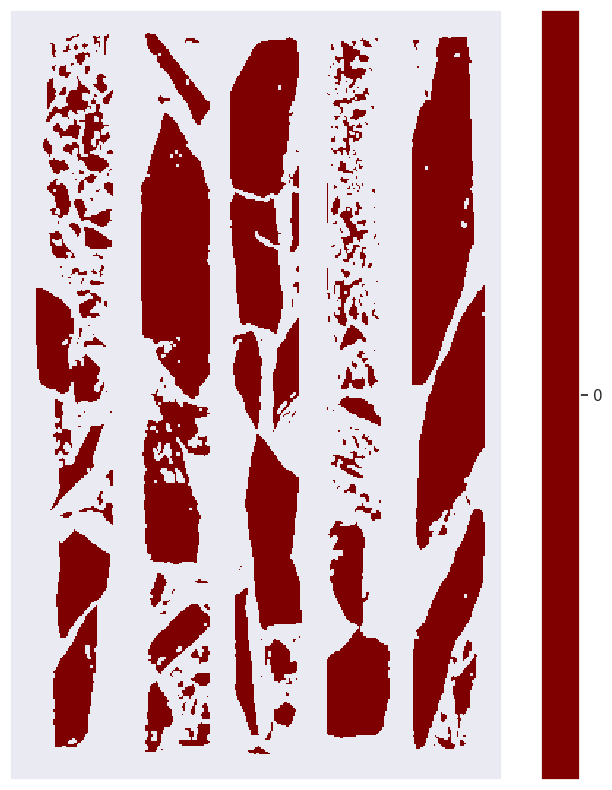

In [ ]:
#Ploting Second Kernels Mask3:

v2 = cm.get_cmap('jet', nc2)

plt.figure(figsize=(10,10))
sns.set()

plt.imshow(labels2, cmap=v2, vmin=-0.5, vmax=nc2-0.5)
plt.colorbar(ticks=np.arange(0,nc2))#, shrink=0.3)
plt.xticks([])
plt.yticks([])

plt.show()

## Set Final Mask

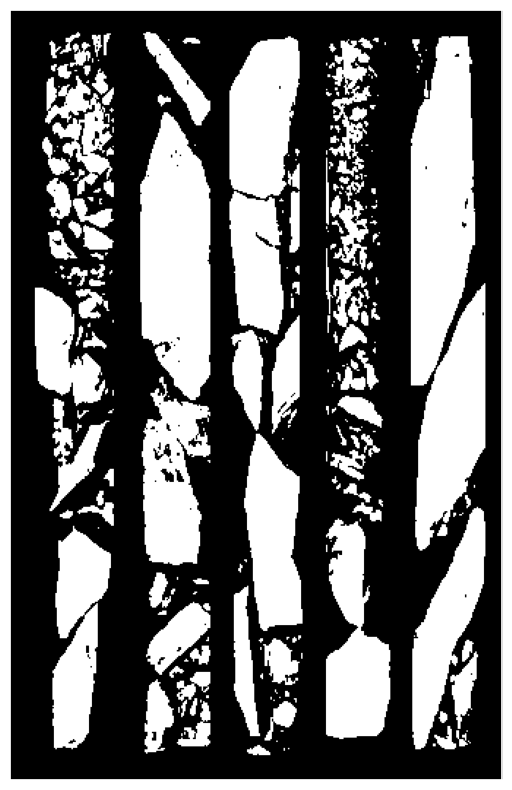

(527, 337)

In [ ]:
#Choose second kernel clusters Mask 3
clusters2 = [0,]

#Create final binary masks
y = (labels2 == clusters2[0])
for i in range(1, len(clusters2)):
    y = np.logical_or(y, labels2 == clusters2[i])

#Plot the finals Mask

plt.figure(figsize=(10,10))
sns.set()

plt.imshow(y, cmap='binary_r')
plt.xticks([])
plt.yticks([])

plt.show()

labels2.shape

In [ ]:
#Reshape the mask
y=y.reshape(-1)

y.shape

(177599,)

## Classification Model

Train Model with Image 1 and the final mask above.


In [ ]:
#MLPclasifier: Multilayer perceptor algorithm.
#alpha: controls L2 regularization, lower alpha = weaker regularization and smaller weights
clf = MLPClassifier(alpha=1e-4,verbose=True)

#Train classifier
clf.fit(H,y);

Iteration 1, loss = 0.12331194
Iteration 2, loss = 0.08445926
Iteration 3, loss = 0.07942583
Iteration 4, loss = 0.07723351
Iteration 5, loss = 0.07558121
Iteration 6, loss = 0.07406608
Iteration 7, loss = 0.07287713
Iteration 8, loss = 0.07193840
Iteration 9, loss = 0.07105216
Iteration 10, loss = 0.07032427
Iteration 11, loss = 0.06957397
Iteration 12, loss = 0.06906569
Iteration 13, loss = 0.06853458
Iteration 14, loss = 0.06802712
Iteration 15, loss = 0.06757159
Iteration 16, loss = 0.06724744
Iteration 17, loss = 0.06681276
Iteration 18, loss = 0.06653106
Iteration 19, loss = 0.06637627
Iteration 20, loss = 0.06607029
Iteration 21, loss = 0.06579242
Iteration 22, loss = 0.06560171
Iteration 23, loss = 0.06538856
Iteration 24, loss = 0.06518188
Iteration 25, loss = 0.06488354
Iteration 26, loss = 0.06481063
Iteration 27, loss = 0.06450400
Iteration 28, loss = 0.06440816
Iteration 29, loss = 0.06435420
Iteration 30, loss = 0.06416297
Iteration 31, loss = 0.06411017
Iteration 32, los

## Build Masker Algorithm with hyperspectrum_models.py

In [ ]:
#Select path for the source .py folder
import sys
# this should be changed to your own google drive path
sys.path.append('/content/drive/MyDrive/SURF/HySpectral Project')

#Import sources .py and data
from source.hyperspectrum_models import Masker
help(Masker)

Help on class Masker in module source.hyperspectrum_models:

class Masker(builtins.object)
 |  Masker(model_pipeline, wavelength_range=None)
 |  
 |  This class produces a callable which inputs a hyperspectral image (crate type)
 |  and outputs a binary mask indicating sections of the image labeled useful (1,True)
 |  and background (0,False).
 |      - model_pipeline : an object with .predict member function that classifies
 |          hyperspectral curves.
 |      - wavelength_range : tuple of length 2, range of usable wavelengths if relevant.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, image)
 |      produces a mask for an image.
 |  
 |  __init__(self, model_pipeline, wavelength_range=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |   

In [ ]:
# Build Masker Algorithm with hyperspectrum_models.py
maskingModel = Masker(
    Pipeline([("preproc",pl),("classifier",clf)]),
    swir_range
)

### Read/Set Data

In [ ]:
#Oppening files

#196 image

#Path of hdr file image2
hdrFile2='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_196_extracted_image.hdr'

#Path of img file image1
imgFile2='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_196_extracted_image.img'

img = envi.open(hdrFile2, imgFile2)
img = img.load()


### Predict masks labels


In [ ]:
#Predict 195, 196, and 197

#195 mask prediction
yHat1 = clf.predict(H)

#Reshape to original
yHat1 = yHat1.reshape(hypr_shape[:2])

#Denoised with wavelet transform
yHat1 = denoise_wavelet(img_as_float(yHat1), sigma=0.15, rescale_sigma=True, method='VisuShrink', wavelet='db2')

#clipped image
yHat1 = np.clip(np.round(yHat1),0,1)


#196 mask prediction
yHat2 = maskingModel(img)

#Denoised with wavelet transform
yHat2 = denoise_wavelet(img_as_float(yHat2), sigma=0.15, rescale_sigma=True, method='VisuShrink', wavelet='db2')

#clipp image
yHat2 = np.clip(np.round(yHat2),0,1)




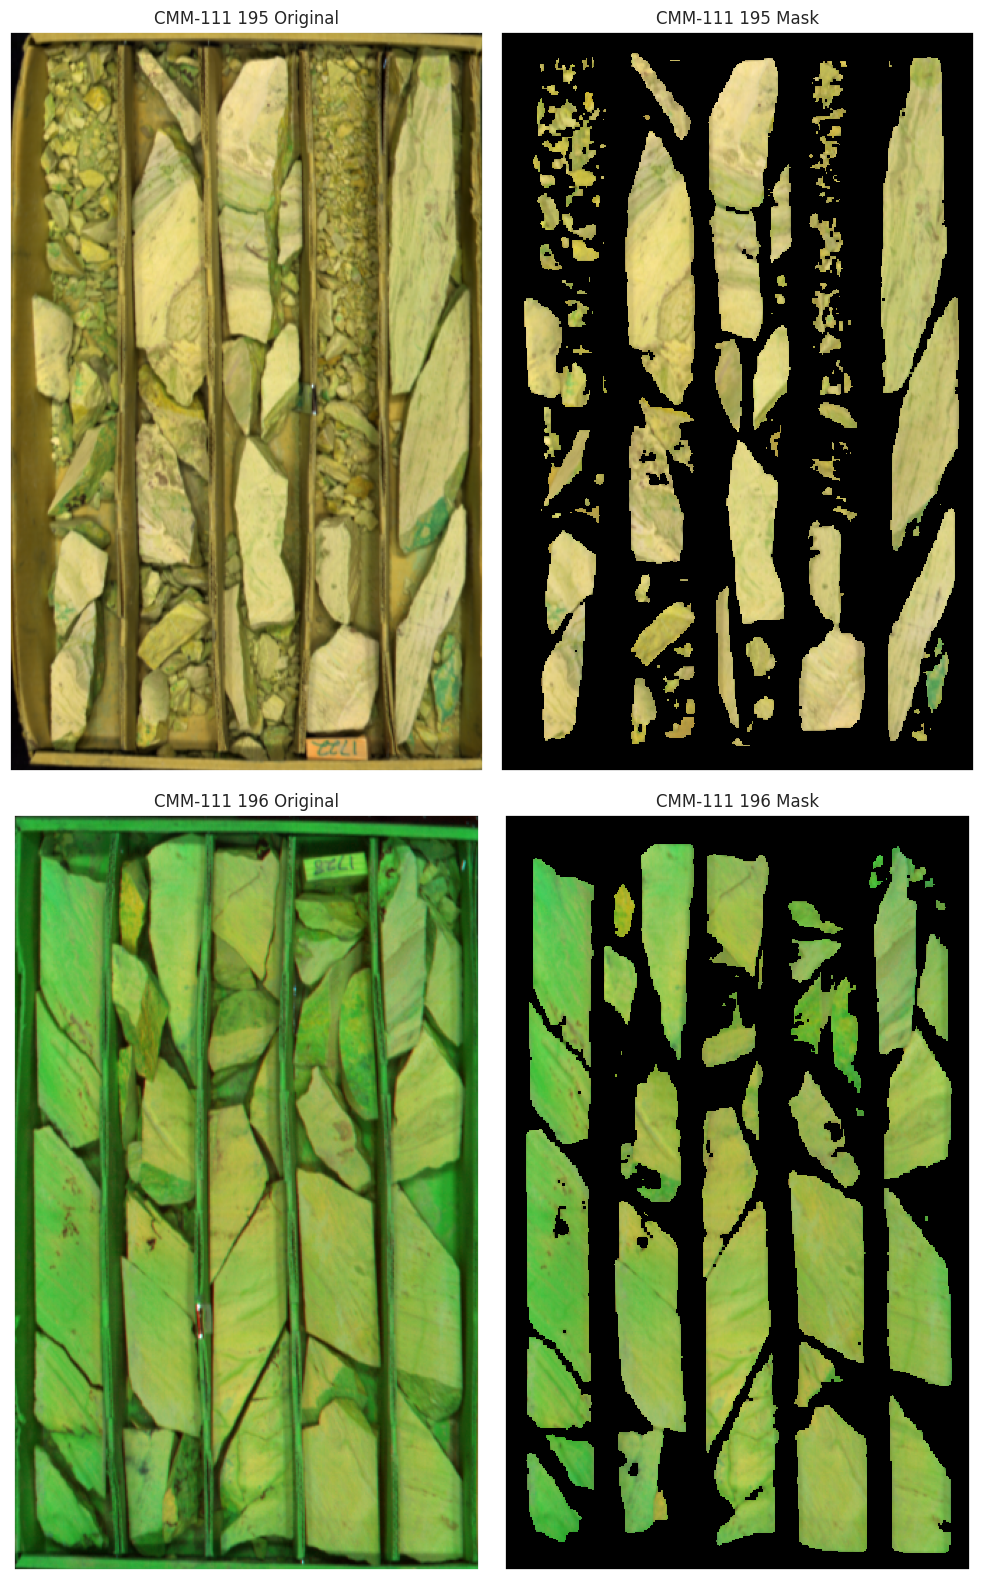

In [ ]:
#plotting results:

plt.figure(figsize=(10,16))

#195

plt.subplot(2,2,1)
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])
plt.title("CMM-111 195 Original")

plt.subplot(2,2,2)
tmp1 = img_rgb.copy(); tmp1[~yHat1.astype(bool)] = np.nan
#print(tmp.shape, yHat.shape)
plt.imshow(tmp1, cmap='binary_r')
plt.xticks([])
plt.yticks([])
plt.title("CMM-111 195 Mask")

#196

#Convert to RGB
img_rgb2=sp.get_rgb(img)

plt.subplot(2,2,3)
plt.imshow(img_rgb2)
plt.xticks([])
plt.yticks([])
plt.title("CMM-111 196 Original")

plt.subplot(2,2,4)
tmp2 = img_rgb2.copy(); tmp2[~yHat2.astype(bool)] = np.nan
#print(tmp.shape, yHat.shape)
plt.imshow(tmp2, cmap='binary_r')
plt.xticks([])
plt.yticks([])
plt.title("CMM-111 196 Mask")

plt.tight_layout()


In [ ]:
#Save the mask image 195
mask3File='/content/drive/MyDrive/SURF/HySpectral Project/data/Trained Mask/195_finermask.tiff'
plt.imsave(mask3File, yHat1)

#Save the mask image 196
mask3File='/content/drive/MyDrive/SURF/HySpectral Project/data/Trained Mask/196_finermask.tiff'
plt.imsave(mask3File, yHat2)

## Save Trained Model

In [ ]:
#Save the trained model on:
savePath='/content/drive/MyDrive/SURF/HySpectral Project/binaries/masker1.joblib'

joblib.dump(maskingModel, savePath) # we save our Masker model for reusing it

['/content/drive/MyDrive/SURF/HySpectral Project/binaries/masker1.joblib']

## Open and use Trained Model

In [ ]:
#Open trained model from .joblib file
openPath=savePath

openedMasker = joblib.load(openPath)

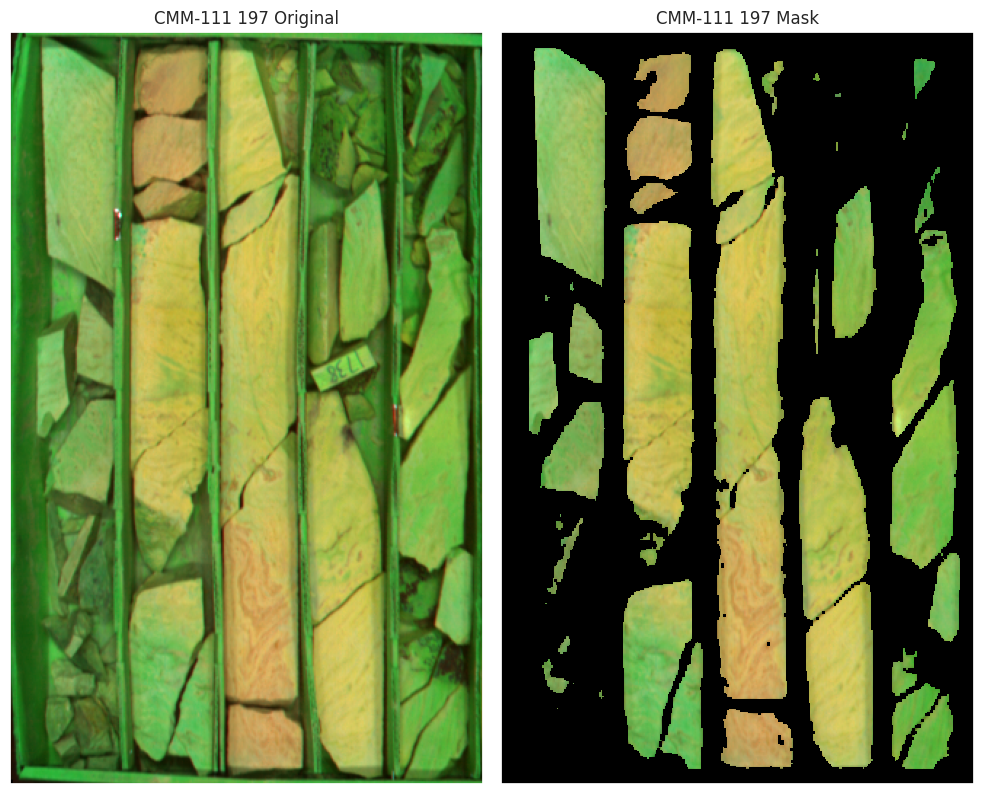

float64


In [ ]:
# Open 197 image

#Path of hdr file image2
hdrFile3='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_197_extracted_image.hdr'

#Path of img file image1
imgFile3='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_197_extracted_image.img'

img3 = envi.open(hdrFile3, imgFile3)
img3 = img3.load()



#197 mask prediction eith the opened Masker
yHat3 = openedMasker(img3)

#Denoised with wavelet transform
yHat3 = denoise_wavelet(img_as_float(yHat3), sigma=0.15, rescale_sigma=True, method='VisuShrink', wavelet='db2')

#clipp image
yHat3 = np.clip(np.round(yHat3),0,1)


#197

#Convert to RGB
img_rgb3=sp.get_rgb(img3)


#Plot results
plt.figure(figsize=(10,16))

plt.subplot(1,2,1)
plt.imshow(img_rgb3)
plt.xticks([])
plt.yticks([])
plt.title("CMM-111 197 Original")

plt.subplot(1,2,2)
tmp3 = img_rgb3.copy(); tmp3[~yHat3.astype(bool)] = np.nan
#print(tmp.shape, yHat.shape)
plt.imshow(tmp3, cmap='binary_r')
plt.xticks([])
plt.yticks([])
plt.title("CMM-111 197 Mask")

# plt.suptitle("CMM-111 196")
plt.tight_layout()
plt.show()

#Check type of mask
print(yHat3.dtype)

In [ ]:
#Save the mask image 197
mask3File='/content/drive/MyDrive/SURF/HySpectral Project/data/Trained Mask/197_finermask.tiff'
plt.imsave(mask3File, yHat3)
